Poisson distribution describe a random variable whose mean and variance both equal to lambda.

It's assumed that the higher the mean, the larger the variance.

It can be used to estimate scenario like:

> there are on average 5 cars going by this road in one hour,
> what's the estimated probability that 3 cars go by this road in an hour?

It can be used when there is no other information about the distribution other than the mean value.

The book doesn't give a convincing and sensible explanation why Gamma distribution is chosen. From wikipedia I learned that Gamma distribution is often used as a prior to find the value of lambda in Poisson distribution. There may be good reasons for this but there is nothing more to be found. I will just take it as granted for now, and hoping my confusion can be clarified in chapter 18.

In [1]:
import numpy as np
from empiricaldist import Pmf
import pandas as pd
from scipy.stats import norm, binom, gamma, poisson

<Axes: >

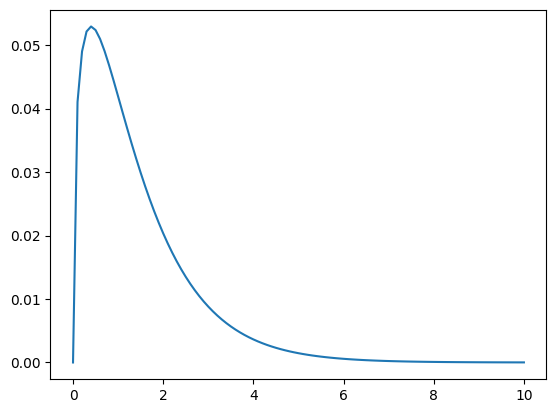

In [2]:
alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)
prior = Pmf(ps, qs)
prior.normalize()
prior.plot()

<Axes: >

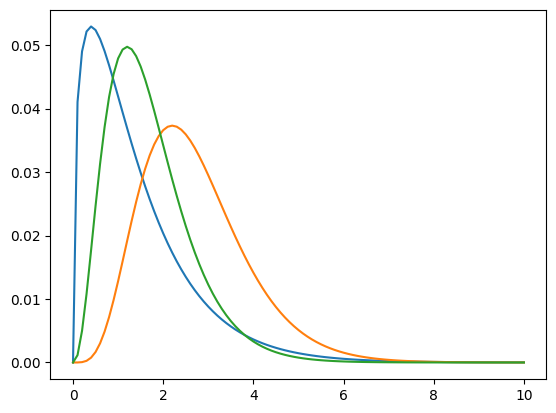

In [3]:
def update(prior, goal):
    qs = prior.qs.copy()
    likelihood = poisson(qs).pmf(goal)
    posterior = prior.copy() * likelihood
    posterior.normalize()
    return posterior

france = update(prior, 4)
croatia = update(prior, 2)
prior.plot()
france.plot()
croatia.plot()

In [4]:
Pmf.prob_gt(france, croatia) # Probability of Superiority

0.7499366290930175

I'm still confused about the difference between the concept of "probability of superiority" and the concept of "winning rate in a single match".

From the book it says "we are more certain about the rate of goals than the winning rate of a match", where the rate of goals is what's used to calculate the "probability of superiority".

In [5]:
def mix(prior, pmfs):
    df = pd.DataFrame(pmfs).fillna(0).transpose()
    df *= np.array(prior)
    return Pmf(df.sum(axis=1))

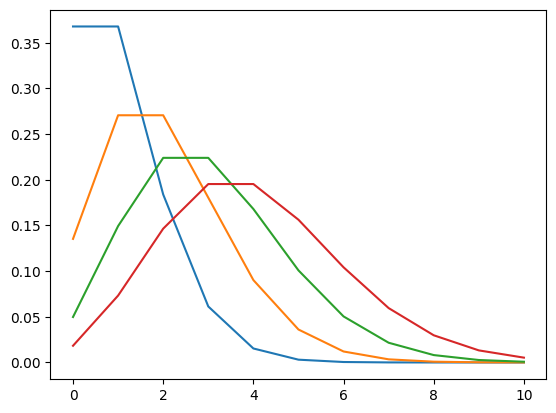

In [6]:
# we don't know about the actual lambda for the poisson distribution, so we just use a mix of some of them (???)
# i don't know why this is it.
goals = np.arange(0, 10+1)
pmfs = [Pmf(poisson(lam).pmf(goals), goals) for lam in [1,2,3,4]]
for pmf in pmfs:
    pmf.plot()

<Axes: >

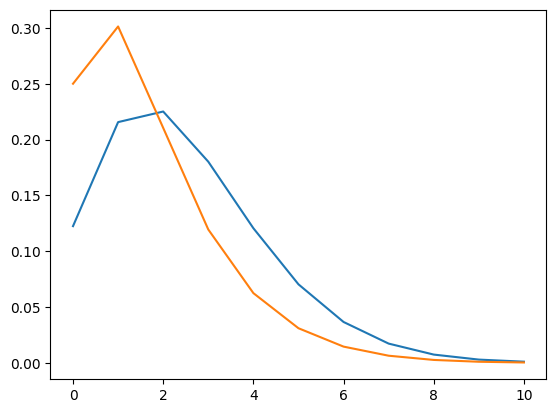

In [7]:
france_goals = mix(france[[1,2,3,4]], pmfs)
croatia_goals = mix(prior[[1,2,3,4]], pmfs)

france_goals.normalize()
croatia_goals.normalize()

france_goals.plot()
croatia_goals.plot()

In [8]:
france_win = Pmf.prob_gt(france_goals, croatia_goals)
croatia_win = Pmf.prob_lt(france_goals, croatia_goals)
tie = Pmf.prob_eq(france_goals, croatia_goals)

(france_win, croatia_win, tie)

(0.55246436968802, 0.27256535797778797, 0.17497027233419235)

<Axes: >

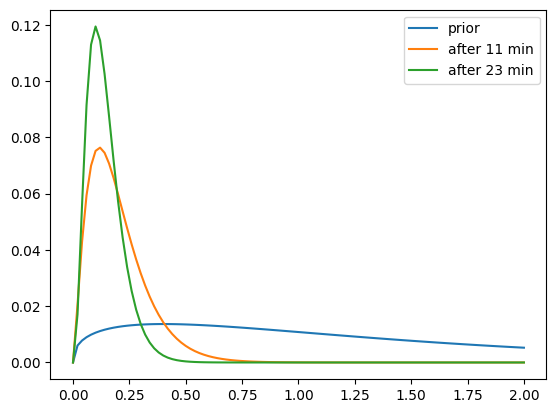

In [9]:
# problem of germany vs brazil
qs = np.linspace(0, 2, 101)
prior = Pmf(gamma(1.4).pdf(qs), qs)
prior.normalize()

def expo(t, lam):
    return lam * np.exp(-lam * t)

def update_goal(prior, goal_min):
    qs = prior.qs
    likelihood = expo(goal_min, qs)
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

posterior = update_goal(prior, 11)
lam_dist = update_goal(posterior, 23-11)
prior.plot(label='prior', legend=True)
posterior.plot(label='after 11 min', legend=True)
lam_dist.plot(label='after 23 min', legend=True)

0.1416508918734613


<Axes: >

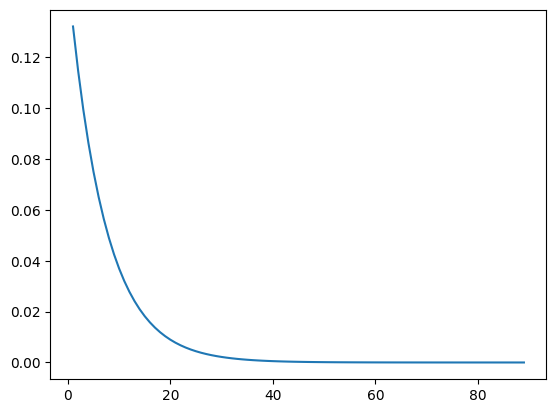

In [10]:
def expo_pmf(ts, lam):
    ps = expo(ts, lam)
    pmf = Pmf(ps, ts)
    pmf.normalize()
    return pmf
    
def expo_pmf_lams(t, lams):
    ps = expo(t, lams)
    pmf = Pmf(ps, lams)
    pmf.normalize()
    return pmf

print(lam_dist.mean())
# this the expected time till next goal given the most likely lambda
expo_pmf(range(1, 90), lam_dist.mean()).plot()

<Axes: title={'center': 'time till next goal'}>

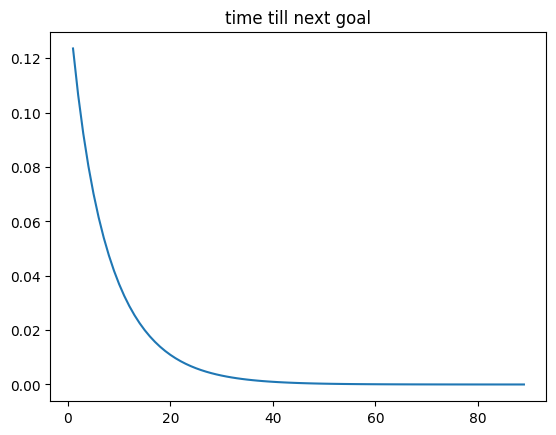

In [11]:
# the red curve is the estimated distribution of lambda for the exponential distribution
# now let's find the distribution of goals after 90 minutes

qs_lams = np.linspace(0.01, 1.0, 10)
qs_time = range(1, 90) # time till next goal

def interpolate(pmf, q):
    if q in pmf:
        return pmf[q]
    pmf[q] = np.nan
    return pmf.interpolate()[q]

prior = Pmf(1, qs_lams)
pmfs = [expo_pmf(qs_time, lam) * interpolate(lam_dist, lam) for lam in qs_lams]
ttng = mix(prior, pmfs)
ttng.normalize()
ttng.plot(title = "time till next goal")

<Axes: title={'center': 'number of predicted goals per game'}>

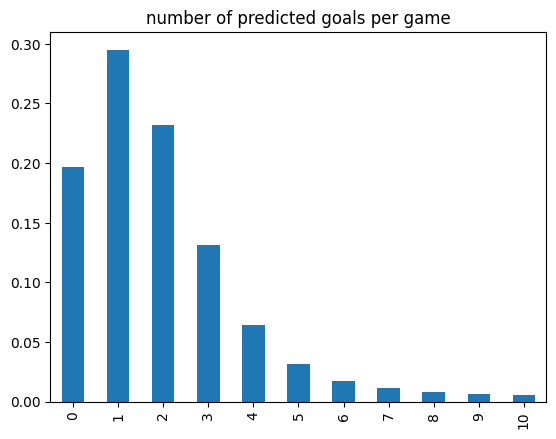

In [12]:
# now let's calculate poisson distribution of alpha sampled from ttng

qs_lams = np.linspace(0.1, 90, 30)
prior = Pmf(1, qs_lams)
prior.normalize()
def poisson_pmf(lam, qs):
    return Pmf(poisson(lam).pmf(qs), qs)

pmfs = [poisson_pmf(90.0 / lam, np.arange(0, 11)) * interpolate(ttng, lam) for lam in qs_lams]
posterior = mix(prior, pmfs)
posterior.normalize()
posterior.plot(kind='bar', title="number of predicted goals per game")

In [38]:
# problem: if croatia and germany plays a rematch, what is the probability that France scores first.

# to solve this, we find the distribution of the time for first goal for each country.
# we stipulate the time of first goal follows an exponential distribution.

# now, we create a pmf for the time of the first goal for each country
hypos = np.linspace(0, 4, 40)
ttfg_france = [expo_pmf(hypos, lam) for lam in france.qs]
ttfg_croatia = [expo_pmf(hypos, lam) for lam in croatia.qs]

<Axes: >

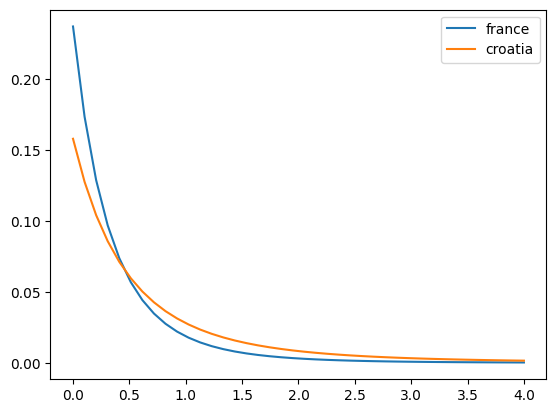

In [39]:
pred_france = mix(france, ttfg_france)
pred_croatia = mix(croatia, ttfg_croatia)

pred_france.plot(label="france", legend=True)
pred_croatia.plot(label="croatia", legend=True)

In [40]:
pred_france.prob_lt(pred_croatia)

0.5605236332448438